In [121]:
!pip install -q tensorflow==2.1.0

In [122]:
!pip install -q tensorflow-quantum

In [123]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [124]:
# tf.keras.backend.clear_session()

In [125]:
def get_data(l):
    data = np.zeros(l,float)
    label = np.ones(l,int)
    data[0::2]=1
    label[1::2] = 0
    p = np.random.permutation(l)
    return data[p], label[p]

def convert_to_circuit(x):
    """Encode truncated classical image into quantum datapoint."""
    qubits = cirq.GridQubit.rect(1, 1)
    circuit = cirq.Circuit()
    if x:
        circuit.append(cirq.X(qubits[0]))
    return circuit

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

In [126]:
s = []
qubit = cirq.GridQubit.rect(1, 1)  # 1x1 grid.
readout = cirq.GridQubit(-1, -1)   # a single qubit at [-1,-1]
model_circuit = cirq.Circuit()

model_circuit.append(cirq.X(readout))
model_circuit.append(cirq.H(readout))

alpha = sympy.Symbol('a')
model_circuit.append(cirq.XX(qubit[0], readout)**alpha)

beta = sympy.Symbol('b')
model_circuit.append(cirq.ZZ(qubit[0], readout)**beta)

model_circuit.append(cirq.H(readout))
model_readout = cirq.Z(readout)

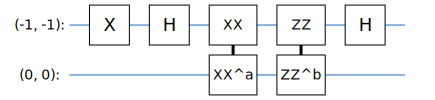

In [127]:
SVGCircuit(model_circuit)

In [128]:
x_train, y_train = get_data(2000)
x_test, y_test = get_data(10)

x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [129]:
print(x_train[:10])
print(y_train[:10])

[1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
[1 1 1 0 1 1 0 0 0 0]


In [130]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0
x_train_tfcirc = x_train
x_test_tfcirc = x_test

In [131]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1)),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=x_train_tfcirc,
                    y=y_train_hinge,
                    epochs=50,
                    verbose=1)

Train on 2000 samples
Epoch 1/50
2000/2000 [==============================] - 0s 143us/sample - loss: 0.0854
Epoch 2/50
2000/2000 [==============================] - 0s 42us/sample - loss: 1.1049e-04
Epoch 3/50
2000/2000 [==============================] - 0s 38us/sample - loss: 1.1046e-07
Epoch 4/50
2000/2000 [==============================] - 0s 45us/sample - loss: 7.8904e-10
Epoch 5/50
2000/2000 [==============================] - 0s 40us/sample - loss: 1.2868e-11
Epoch 6/50
2000/2000 [==============================] - 0s 39us/sample - loss: 1.3366e-12
Epoch 7/50
2000/2000 [==============================] - 0s 43us/sample - loss: 5.3696e-14
Epoch 8/50
2000/2000 [==============================] - 0s 39us/sample - loss: 2.9853e-13
Epoch 9/50
2000/2000 [==============================] - 0s 42us/sample - loss: 9.9246e-13
Epoch 10/50
2000/2000 [==============================] - 0s 45us/sample - loss: 9.9335e-13
Epoch 11/50
2000/2000 [==============================] - 0s 39us/sample - loss: 

In [132]:
print(list(zip(model.predict(x_test_tfcirc).ravel(), y_test)))

[(1.0, 1), (-1.0, 0), (-1.0, 0), (1.0, 1), (-1.0, 0), (-1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (-1.0, 0)]
